In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision import utils as vutils

In [3]:
PATH_DATASETS = ''
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

In [3]:
transform = transforms.Compose([transforms.Resize(28),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5))])

In [6]:
dataset = MNIST(PATH_DATASETS, train=True, download=True, 
                 transform=transform)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)
print(dataset.data.shape)

torch.Size([60000, 28, 28])


In [7]:
nz = 100
ngf = 64
ndf = 64

In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02) # Batch Normalization 層權重初始值 
        m.bias.data.fill_(0)

In [26]:
class Generator(nn.Module):
    def __init__(self, nc = 1, nz = 100, ngf = 64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
        nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias = False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),
        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias = False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),
        nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias = False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        nn.ConvTranspose2d(ngf, nc, kernel_size=1, 
                           stride=1, padding=2, bias=False),
        nn.Tanh()
        )
    def forward(self, input):
        output = self.main(input)
        return output
netG = Generator().to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)

In [27]:
class Discriminator(nn.Module):
    def __init__(self, nc = 1, ndf = 64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
        nn.Conv2d(nc, ndf, 4, 2, 1, bias = False),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*4) x 8 x 8
        nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
        nn.Sigmoid()
    )
    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)
netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [28]:
criterion = nn.BCELoss()

optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [29]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)


In [42]:
fixed_noise = torch.randn(64, nz ,1, 1, device = device)
real_label = 1.0
fake_label = 0.0
niter = 25
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size, ), real_label, device = device)
        
        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(batch_size, nz, 1, 1, device = device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        if i % 200 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                   % (epoch+1, niter, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            vutils.save_image(real_cpu,'gan_output/real_samples.png' ,normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),'gan_output/fake_samples_epoch_%03d.png' 
                              % (epoch), normalize=True)        
    torch.save(netG.state_dict(), 'gan_weights/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), 'gan_weights/netD_epoch_%d.pth' % (epoch))
        

[1/25][0/938] Loss_D: 1.5396 Loss_G: 1.0785 D(x): 0.5907 D(G(z)): 0.6079 / 0.3588
[1/25][200/938] Loss_D: 0.5629 Loss_G: 3.2070 D(x): 0.6484 D(G(z)): 0.0671 / 0.0620
[1/25][400/938] Loss_D: 0.3028 Loss_G: 2.7228 D(x): 0.8890 D(G(z)): 0.1575 / 0.0788
[1/25][600/938] Loss_D: 0.4788 Loss_G: 1.7783 D(x): 0.7817 D(G(z)): 0.1897 / 0.1977
[1/25][800/938] Loss_D: 0.8187 Loss_G: 0.6923 D(x): 0.5259 D(G(z)): 0.1101 / 0.5328
[2/25][0/938] Loss_D: 0.5863 Loss_G: 2.0951 D(x): 0.7964 D(G(z)): 0.2718 / 0.1465
[2/25][200/938] Loss_D: 0.8330 Loss_G: 1.3792 D(x): 0.6518 D(G(z)): 0.3002 / 0.2712
[2/25][400/938] Loss_D: 0.6384 Loss_G: 1.4249 D(x): 0.6499 D(G(z)): 0.1461 / 0.2685
[2/25][600/938] Loss_D: 0.7956 Loss_G: 1.3142 D(x): 0.6006 D(G(z)): 0.1991 / 0.2991
[2/25][800/938] Loss_D: 0.8950 Loss_G: 1.6518 D(x): 0.6731 D(G(z)): 0.3494 / 0.2183
[3/25][0/938] Loss_D: 0.8714 Loss_G: 1.4654 D(x): 0.6661 D(G(z)): 0.3226 / 0.2571
[3/25][200/938] Loss_D: 0.8298 Loss_G: 1.4147 D(x): 0.6259 D(G(z)): 0.2528 / 0.283

[20/25][600/938] Loss_D: 0.8445 Loss_G: 1.3886 D(x): 0.6406 D(G(z)): 0.2715 / 0.2953
[20/25][800/938] Loss_D: 1.0865 Loss_G: 1.1568 D(x): 0.4687 D(G(z)): 0.1839 / 0.3568
[21/25][0/938] Loss_D: 0.9636 Loss_G: 1.5671 D(x): 0.7055 D(G(z)): 0.3895 / 0.2517
[21/25][200/938] Loss_D: 0.8011 Loss_G: 2.1249 D(x): 0.6852 D(G(z)): 0.2922 / 0.1477
[21/25][400/938] Loss_D: 1.0551 Loss_G: 2.3680 D(x): 0.8697 D(G(z)): 0.5594 / 0.1132
[21/25][600/938] Loss_D: 0.8488 Loss_G: 2.0721 D(x): 0.7927 D(G(z)): 0.3904 / 0.1554
[21/25][800/938] Loss_D: 0.8386 Loss_G: 1.5101 D(x): 0.5716 D(G(z)): 0.1879 / 0.2504
[22/25][0/938] Loss_D: 1.1301 Loss_G: 2.8639 D(x): 0.8595 D(G(z)): 0.5720 / 0.0734
[22/25][200/938] Loss_D: 0.9198 Loss_G: 1.8359 D(x): 0.7064 D(G(z)): 0.3574 / 0.2105
[22/25][400/938] Loss_D: 0.9115 Loss_G: 1.5219 D(x): 0.6786 D(G(z)): 0.3496 / 0.2479
[22/25][600/938] Loss_D: 0.7756 Loss_G: 1.5969 D(x): 0.6362 D(G(z)): 0.2078 / 0.2425
[22/25][800/938] Loss_D: 0.6981 Loss_G: 2.0636 D(x): 0.7015 D(G(z)): 

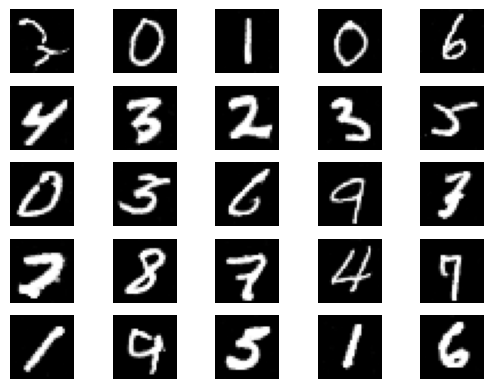

In [43]:
import matplotlib.pyplot as plt
batch_size = 25
latent_size = 100
fixed_noise = torch.randn(batch_size, latent_size, 1, 1).to(device)
fake_images = netG(fixed_noise)
fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.axis('off')
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()

In [44]:
import imageio
import glob

# 產生 GIF 檔
anim_file = './gan_output/dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./gan_output/fake_samples*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image) 

# DCGAN 人臉產生

In [4]:
import os 
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision import datasets
from torchvision import utils as vutils
import matplotlib.pyplot as plt
import numpy as np


In [5]:
PATH_DATASETS = "" # 預設路徑
BATCH_SIZE = 128  # 批量
image_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

In [6]:
nz = 100
ngf = 64
ndf = 64
nc = 3

In [7]:
transform = transforms.Compose([
    transforms.Resize(image_size), 
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [8]:
dataset = datasets.ImageFolder(root = 'celeba_gan',
                              transform = transform)
dataloader = torch.utils.data.DataLoader(dataset
                   , batch_size=BATCH_SIZE, shuffle=True)

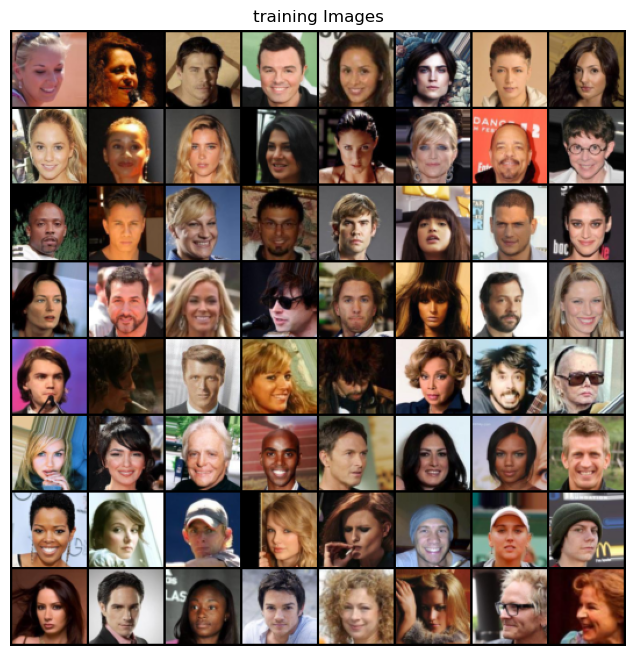

In [9]:
real_batch = next(iter(dataloader))
plt.figure(figsize = (8, 8))
plt.axis('off')
plt.title('training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64]
                     , padding=2, normalize=True).cpu(),(1,2,0)))

In [15]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02) # Batch Normalization 層權重初始值 
        m.bias.data.fill_(0)

In [16]:
class Generator(nn.Module):
    def __init__(self, nc=3, nz=100, ngf=ngf):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output
    
netG = Generator().to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [17]:
class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [18]:
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [19]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.0
fake_label = 0.0
niter = 10
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device = device)
        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(batch_size, nz, 1, 1, device = device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        if i % 200 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                   % (epoch+1, niter, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            vutils.save_image(real_cpu,'gan_face_output/real_samples.png' ,normalize=True)
            fake = netG(fixed_noise) 
            vutils.save_image(fake.detach(),'gan_face_output/fake_samples_epoch_%03d.png' 
                              % (epoch), normalize=True)
    torch.save(netG.state_dict(), 'gan_face_weights/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), 'gan_face_weights/netD_epoch_%d.pth' % (epoch))

[1/10][0/1583] Loss_D: 2.0602 Loss_G: 5.2245 D(x): 0.5414 D(G(z)): 0.6761 / 0.0084
[1/10][200/1583] Loss_D: 0.2177 Loss_G: 5.3594 D(x): 0.8835 D(G(z)): 0.0587 / 0.0087
[1/10][400/1583] Loss_D: 0.3832 Loss_G: 4.7086 D(x): 0.8126 D(G(z)): 0.1020 / 0.0177
[1/10][600/1583] Loss_D: 0.5189 Loss_G: 4.9850 D(x): 0.8781 D(G(z)): 0.2622 / 0.0126
[1/10][800/1583] Loss_D: 0.2047 Loss_G: 5.1315 D(x): 0.9163 D(G(z)): 0.0934 / 0.0103
[1/10][1000/1583] Loss_D: 0.4292 Loss_G: 3.6347 D(x): 0.8405 D(G(z)): 0.1658 / 0.0510
[1/10][1200/1583] Loss_D: 0.7042 Loss_G: 3.1629 D(x): 0.6342 D(G(z)): 0.0515 / 0.0812
[1/10][1400/1583] Loss_D: 1.0955 Loss_G: 5.9935 D(x): 0.9031 D(G(z)): 0.5247 / 0.0062
[2/10][0/1583] Loss_D: 0.4688 Loss_G: 3.7076 D(x): 0.8133 D(G(z)): 0.1690 / 0.0388
[2/10][200/1583] Loss_D: 0.3703 Loss_G: 4.4934 D(x): 0.8749 D(G(z)): 0.1673 / 0.0210
[2/10][400/1583] Loss_D: 0.5400 Loss_G: 3.9431 D(x): 0.8798 D(G(z)): 0.2995 / 0.0298
[2/10][600/1583] Loss_D: 0.4902 Loss_G: 2.9426 D(x): 0.7720 D(G(z)

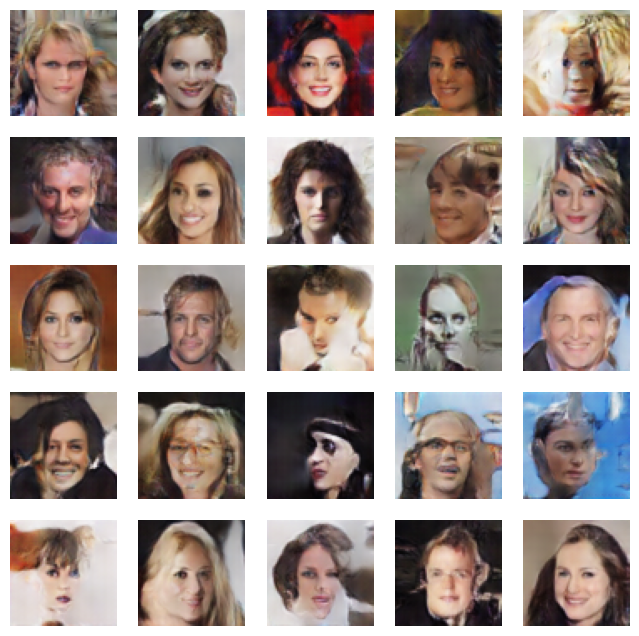

In [21]:
batch_size = 25
latent_size = 100
fixed_noise = torch.randn(batch_size, latent_size, 1, 1).to(device)
fake_images = netG(fixed_noise).clamp(min=-1, max=1)
fake_images_np = fake_images.cpu()
fake_images_np = fake_images_np.reshape(-1, 3, image_size, image_size)
fake_images_np = torch.permute(fake_images_np, (0, 2, 3, 1)).detach().numpy()
fake_images_np = (fake_images_np + 1) *.5  # 使像素值介於 [0, 1] 之間
R, C = 5, 5
plt.figure(figsize=(8, 8))
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.axis('off')
    plt.imshow(fake_images_np[i])
plt.show();

In [22]:
import imageio
import glob

# 產生 GIF 檔
anim_file = './gan_face_output/dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./gan_face_output/fake_samples*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image) 

In [23]:
netD.load_state_dict(torch.load('gan_face_weights/netD_epoch_9.pth'))
netG.load_state_dict(torch.load('gan_face_weights/netG_epoch_9.pth'))

<All keys matched successfully>